In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from torch.utils.data import Dataset
import scipy.io
import torch
!pwd

sys.path.append('../')
from module.Pingfan_ver2_datamodule import MRIDataModule
from script.trainer import our_GRU, model_load_matcher

/mnt/ssd/jj/Research/cauMedical/lightning_bolts/script


# Datamodule

In [3]:
import pwd
import pytorch_lightning as pl
import torch
import torchvision
from torch.utils.data import random_split, DataLoader, Dataset
import numpy as np
import os
import scipy.io
import sys

sys.path.append('../')
from script.trainer import BlochSeqEqDecoder, BlochImgEqDecoder
from Bloch_decoder.utils.generate_RF_TR import generate_RF_TR


class MRIDataModule(pl.LightningDataModule):
    def __init__(
        self, batch_size: int = 1, num_workers=0, test_type="seq", is_split_range_T1T2=False, subsamp=1, seq_jump=5, is_input_RF=0, need_T1T2_logscale=False, need_TETR_second=False,need_RF_degree=False,
    ):  # img_cnn, img_seq, seq
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.test_type = test_type
        self.subsamp = subsamp
        self.seq_jump = seq_jump
        self.need_T1T2_logscale = need_T1T2_logscale
        self.need_TETR_second = need_TETR_second
        self.need_RF_degree = need_RF_degree
        self.datamodule = PingSeqDataset
        self.is_split_range_T1T2 = is_split_range_T1T2

    def prepare_data(self):
        return

    def setup(self, stage=None):
        if "img" in self.test_type:
            self.trainset = self.datamodule(mode='train', is_split_range_T1T2=self.is_split_range_T1T2, need_T1T2_logscale=self.need_T1T2_logscale, need_TETR_second=self.need_TETR_second, need_RF_degree=self.need_RF_degree)
            self.testset = PingImgDataset_seperate_RF(mode='test', is_split_range_T1T2=self.is_split_range_T1T2, need_T1T2_logscale=self.need_T1T2_logscale, need_TETR_second=self.need_TETR_second, need_RF_degree=self.need_RF_degree)
        else:
            self.trainset = self.datamodule(mode='train', is_split_range_T1T2=self.is_split_range_T1T2, need_T1T2_logscale=self.need_T1T2_logscale, need_TETR_second=self.need_TETR_second, need_RF_degree=self.need_RF_degree)
            self.testset = self.datamodule(mode='test', is_split_range_T1T2=self.is_split_range_T1T2, need_T1T2_logscale=self.need_T1T2_logscale, need_TETR_second=self.need_TETR_second, need_RF_degree=self.need_RF_degree)
            
    def train_dataloader(self):
        return DataLoader(self.trainset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.testset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        if "img" in self.test_type:
             return DataLoader(self.testset, batch_size=128*128, shuffle=False, num_workers=self.num_workers)
        return DataLoader(self.testset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def predict_dataloader(self):
        return DataLoader(self.testset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

class PingSeqDataset(Dataset):
    # Input : T1T2, RF, TE, TR
    def __init__(self, mode='train', is_split_range_T1T2=True, need_T1T2_logscale=False, need_TETR_second=False, need_RF_degree=False):
        """
        Approx RNN input : (need_T1T2_logscale=True, need_TETR_second=True, need_RF_degree=True)
        Our Bloch decoder input : (need_T1T2_logscale=False, need_TETR_second=False, need_RF_degree=False)
        This data : (need_T1T2_logscale=False, need_TETR_second=False, need_RF_degree=False)
        """

        L=1000
        subsamp=1
        MRFData = scipy.io.loadmat('../Bloch_decoder/data/Pingfan/D_LUT_L1000_TE10_Start1_Train.mat') 
        MRFData_Val = scipy.io.loadmat('../Bloch_decoder/data/Pingfan/D_LUT_L1000_TE10_Start5_Val.mat') #
        self.labels = np.concatenate((MRFData['LUT'], MRFData_Val['LUT']),0)
        self.D = np.concatenate((np.real(MRFData['D']), np.real(MRFData_Val['D'])),0)
        self.D = torch.from_numpy(np.real(MRFData['D'][:,0:L:subsamp]))
        self.D = torch.nn.functional.normalize(self.D, p=2.0, dim=1)
        self.labels = torch.from_numpy(MRFData['LUT']) 

        if is_split_range_T1T2:
            # Split train and test set : T1 0~2500, 2500~5000
            T1 = self.labels[:,0]
            T2 = self.labels[:,1]
            condition = (T1<2500)&(T2<1000) if 'train' in mode else (T1>2500)&(T2>1000)
            self.labels = self.labels[condition]
            self.D = self.D[condition]
        
        # T1T2 scale
        len_seq = L//subsamp
        self.T1 = self.labels[:,0].unsqueeze(1).repeat(1, len_seq).unsqueeze(1)
        self.T2 = self.labels[:,1].unsqueeze(1).repeat(1, len_seq).unsqueeze(1)
        if need_T1T2_logscale == True:
            self.T1 = torch.log10(self.T1)
            self.T2 = torch.log10(self.T2)

        # RF, TR, TE
        RFpulses, TR = generate_RF_TR(L)  #%Load slowly changing RF and TR values
        RFpulses = RFpulses[0:L:subsamp]  #% undersampling in time dimension.
        # RFpulses = RFpulses * 1j  # %to avoid complex values of X and D
        self.RFpulses = RFpulses.repeat(len(self.labels),1).unsqueeze(1)
        self.TR = TR[0:L:subsamp].repeat(len(self.labels),1).unsqueeze(1)
        self.TE = torch.ones(len(self.labels), 1, len_seq)*10

        if need_RF_degree == True:
            self.RFpulses = self.RFpulses * 180 / torch.pi

        if need_TETR_second == True:
            self.TR = self.TR/1000
            self.TE = self.TE/1000
                
        # Concat
        self.labels = torch.cat((self.RFpulses, self.T1, self.T2, self.TE, self.TR),1).transpose(1,2) # (80100, 5, 200)
        
        # This if for Debug
        # self.labels = self.labels[0:20]
        # self.D = self.D[0:20]

    def __len__(self):
        return len(self.D)

    def __getitem__(self, idx):
        return self.D[idx], self.labels[idx]




In [4]:
data_module = MRIDataModule(
            batch_size=40, num_workers=4, test_type="seq", is_split_range_T1T2=True, subsamp=1, seq_jump=5, is_input_RF=1,
            need_T1T2_logscale=True, need_TETR_second=True, need_RF_degree=True,
        )
data_module.prepare_data()
data_module.setup()

train_loader = data_module.train_dataloader()
test_loader = data_module.test_dataloader()

batch = next(iter(train_loader))
batch_test = next(iter(test_loader))

# Run model

In [5]:
class BlochSeqEqDecoder_our_RNN:
    def __init__(self, model_dir): # L=1000, subsamp=5, TE=10):  # larger subsamp makes shorter length
        self.simulator = our_GRU()
        self.simulator.load_state_dict(model_load_matcher(model_dir))
        self.simulator.cuda()
        # self.simulator.eval()

    def RNN_forward(self, z):
        z = z.transpose(1,2) # z : (batch, length, 5)  transpose(0,1).transpose(0,2)
        h_init = self.simulator.init_hidden_set(batch_size=len(z))
        seq = self.simulator.forward(z, h_init)
        seq = seq.squeeze(-1)
        return seq
        
    def forward(self, batch):
        """
        # z : (n,5, length)- 5: RFpulses, T1, T2, TE, TR
        # x : (n, length)
        # out : (n, length)
        """
        x, z = batch
        # z = z.transpose(1,2) # z : (batch, length, 5)  transpose(0,1).transpose(0,2)
        h_init = self.simulator.init_hidden_set(batch_size=len(z))
        seq = self.simulator.forward(z, h_init)
        seq = seq.squeeze(-1)
        return seq

In [6]:
def check_our_RNN(batch, model_dir):
    decoder = BlochSeqEqDecoder_our_RNN(model_dir)
    x, z = batch

    # variables
    TE = z[:,:,3].unsqueeze(-1) # TE: (n, length, 1)
    TR = z[:,:,2].unsqueeze(-1) # TR: (n, length, 1)
    RF = z[:,:,0].unsqueeze(-1) # RF: (n, length, 1)
    T1T2 = z[:,0,1:3].unsqueeze(-1).repeat(1,1,TE.shape[1]).transpose(1,2) # T1T2: (n, length, 2)

    # decoder
    z_hat = torch.cat((RF, T1T2, TE, TR),2)
    x_hat = decoder.forward((x,z_hat.cuda())).squeeze(-1)

    return x, x_hat


In [7]:
exp_id = 'SPLIT-13'
model_dir = '/mnt/ssd/jj/Research/cauMedical/output/Split/'+str(exp_id)+'/last.ckpt' #'../script/RNN_model/RNN_epoch200_SPLIT_1.ckpt'
x, x_hat = check_our_RNN(batch, model_dir)


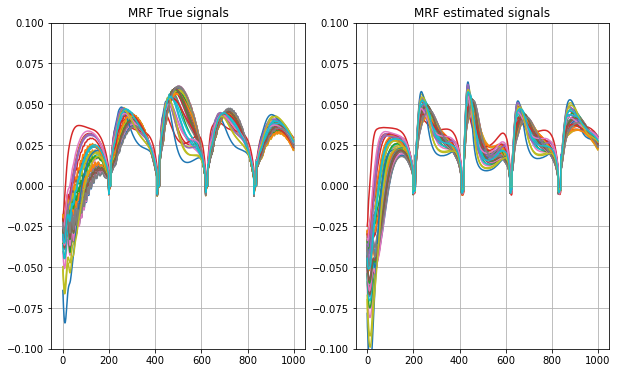

In [13]:
plt.figure(figsize = (10,6) )

plt.subplot(1,2,1)
plt.ylim([-0.1,0.1])
plt.plot(np.real(x.T))
plt.title('MRF True signals')
plt.grid(True)

plt.subplot(1,2,2)
plt.ylim([-0.1,0.1])
plt.plot(np.real(x_hat.detach().cpu().T))
plt.title('MRF estimated signals')
plt.grid(True)
plt.show()

In [17]:
# Get loss
import torch.nn.functional as F
print(x.shape, x_hat.shape)
F.mse_loss(x.detach().cpu(), x_hat.detach().cpu(), reduction="mean")

torch.Size([40, 1000]) torch.Size([40, 1000])


tensor(0.0001)

In [9]:
plt.savefig("RNN_approximation.png")

<Figure size 432x288 with 0 Axes>